In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from scipy import interpolate
from sklearn.calibration import LabelEncoder
color = sns.color_palette()

In [117]:
# train_origin=pd.read_csv("data/round2_train.txt",sep=" ")

# np.random.seed(0)  
# # 按照列的比例随机抽取数据  
# train_sample_ratio = 0.01  # 设置抽样比例为1%  
# train = train_origin.sample(frac=train_sample_ratio, random_state=0)  
  

# 随机抽样：按照比例从原train数据集里抽取1%数据，大约十万条

In [13]:
path = '/Users/apple/Desktop/data/basicclick_data/'
data=pd.read_csv(path+"data_all.csv")
data = data.drop_duplicates(subset='instance_id')
data.shape

(99085, 28)

## 时间戳拆分：时间转为时间戳格式，并将天、小时、分钟拆分出来

In [14]:
#时间数据处理
data['time'] = pd.to_datetime(data.context_timestamp, unit='s')
data['time'] = data['time'].apply(lambda x: x + datetime.timedelta(hours=8)) # 考虑时区，假设是北京时间（UTC+8）  
data['day'] = data['time'].apply(lambda x: int(str(x)[8:10]))#日期只有9月1-6还有31日
data['hour'] = data['time'].apply(lambda x: int(str(x)[11:13]))   
data['minute'] =  data['time'].apply(lambda x: int(str(x)[14:16]))

## 时间分段：将一天中的不同小时映射到对应的时间段分类，如早晨、上午、下午和晚上

In [16]:
#对一天中的不同时间段进行分类或分析。
def map_hour(s):
    if s < 6:#凌晨时段
        return 1
    elif s < 12:#上午时段
        return 2
    elif s < 18:#下午时段
        return 3
    else:#夜间时段
        return 4
    
data['maphour'] = data['hour'].map(map_hour)#将一天中的不同小时映射到对应的时间段分类，如早晨、上午、下午和晚上
data['mapmin'] = data['minute'] % 15 + 1#将分钟数划分为 1 到 15 的区间


data['minute'] 表示从数据集中选择名为 "minute" 的列，该列包含时间的分钟部分。
% 15 表示取分钟数除以15的余数。这将把分钟数映射到0到14的范围。
+ 1 表示将上一步得到的结果加1，使映射范围变为1到15，而不是0到14。
最后，将得到的映射结果赋值给新的列 data['mapmin']。

In [17]:
data.columns

Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'time', 'day', 'hour', 'minute',
       'maphour', 'mapmin'],
      dtype='object')

In [18]:
# 使用分号分割item_category_list，并添加前缀
data_item_category = data.item_category_list.str.split(';', expand=True).add_prefix('item_category_')

# 将分割后的列添加到原数据框
for i in range(3):
    data['item_category_'+str(i)] =  data_item_category['item_category_'+str(i)]     

# 将item_category_1列的值转换为整数类型
data['item_category_1'] = data['item_category_1'].apply(int)

# 对item_category_2列的缺失值进行填充，然后转换为整数类型
data['item_category_2'].fillna(value=0, inplace=True)
data['item_category_2'] = data['item_category_2'].apply(int)

del data['item_category_list']

In [19]:
del data['item_property_list']

In [20]:
#因为模型通常要求输入为数字形式。标签编码用于将分类变量转换为数字形式，而舍入则用于控制数值特征的精度。
#对于label中的列（context_page_id, shop_star_level, user_age_level, user_occupation_id, user_star_level），使用LabelEncoder进行标签编码。这将每个类别映射到一个整数值。
label = ['item_category_0','item_category_1',  'item_category_2', 'context_id',  'item_brand_id', 'item_city_id', 'item_id', 'user_id', 'shop_id']
for col in label:
    col_encoder = LabelEncoder()
    col_encoder.fit(data[col])
    data[col] = col_encoder.transform(data[col])

In [21]:
data['predict_category_property']

0         7019356017454119206:-1;1495388799908940789:-1;...
1         836752724084922533:-1;8658630417297894718:-1;8...
2         1036082357054043890:2636395404473730413;361378...
3         1852600517265062354:2636395404473730413;836752...
4         4911723539855588624:-1;4993377953084092565:-1;...
                                ...                        
104315    836752724084922533:9148482949976129397,1877322...
104316    1036082357054043890:-1;8826467575698439758:513...
104317    768579787521575291:2636395404473730413,3540471...
104318    6670526099037031245:5131280576272319091,839988...
104319    6693726201323251689:-1;836752724084922533:1972...
Name: predict_category_property, Length: 99085, dtype: object

In [22]:
del data['predict_category_property']

In [23]:
#对于short_label中的列（context_page_id, shop_star_level, user_age_level, user_occupation_id, user_star_level），同样使用LabelEncoder进行标签编码。
short_label = ['context_page_id', 'shop_star_level', 'user_age_level', 'user_occupation_id', 'user_star_level']
for col in short_label:
    col_encoder = LabelEncoder()
    col_encoder.fit(data[col])
    data[col] = col_encoder.transform(data[col])


#对于score_label中的列（shop_score_service, shop_review_positive_rate, shop_score_delivery, shop_score_description），使用round函数将数值四舍五入到三位小数。
score_label = ['shop_score_service', 'shop_review_positive_rate', 'shop_score_delivery', 'shop_score_description']
for col in score_label:
    data[col] = round(data[col], 3)

In [24]:
data.head(3)

,instance_id,item_id,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,...,is_trade,time,day,hour,minute,maphour,mapmin,item_category_0,item_category_1,item_category_2
0,7.548380e+18,8583,4236,84,8,11,11,17,65710,0,...,0,2018-09-03 19:13:02,3,19,13,4,14,0,16,8
1,5.975220e+18,7946,2671,110,7,9,13,16,46416,0,...,0,2018-09-06 12:09:32,6,12,9,3,10,0,19,43
2,7.640080e+18,843,3603,110,5,10,13,16,85350,0,...,0,2018-09-03 21:53:39,3,21,53,4,9,0,16,4


In [25]:
path = '/Users/apple/Desktop/data/basicclick_data/'
# 将列和数据类型存储为 DataFrame
columns_data_types = pd.DataFrame({'Column': data.columns, 'Data Type':data.dtypes})

# 保存为 CSV 文件
columns_data_types.to_csv(path+'columns_data_types0.csv', index=False)

切分测试集和训练集

In [26]:
from sklearn.model_selection import train_test_split

train_all,test_all = train_test_split(data, test_size=0.2, random_state=42)


In [27]:
# 查看数据集中的空值
missing_values = train_all.isnull()

# 统计每列的空值数量
missing_count = train_all.isnull().sum()


In [28]:
print(train_all.shape)
print(test_all.shape)

(79268, 33)
(19817, 33)


In [29]:
# 7号数据集
data_day7 = data.loc[(data.day==7)]

train_day7,test_day7 = train_test_split(data_day7, test_size=0.2, random_state=42)

In [30]:
print(train_day7.shape)
print(test_day7.shape)

(8147, 33)
(2037, 33)


In [135]:

train_all.to_csv(path+'train_all.csv', index=False)
test_all.to_csv(path+'test_all.csv', index=False)

train_day7.to_csv(path+'train_day7.csv', index=False)
test_day7.to_csv(path+'test_day7.csv', index=False)


# EDA

In [136]:
data.shape

(99085, 33)

# 针对单一的实例进行如下分析

## 不同时间下事件发生数量

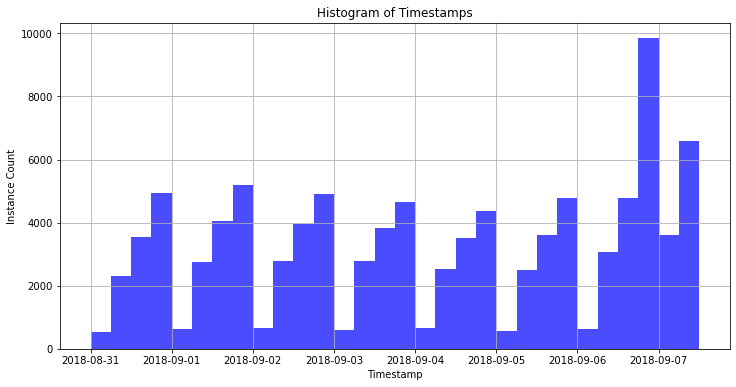

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(data['time'], bins=30, color='b', alpha=0.7)
plt.title('Histogram of Timestamps')
plt.xlabel('Timestamp')
plt.ylabel('Instance Count')
plt.grid(True)
plt.show()

## 每天各小时的事件发生数量

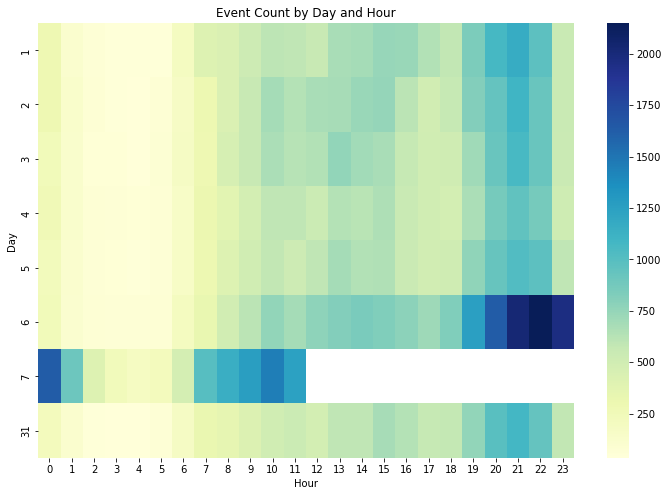

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

# 创建一个新的DataFrame，包含日期、小时和事件数量
hourly_counts = data.groupby(['day', 'hour']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(hourly_counts, cmap="YlGnBu")
plt.title("Event Count by Day and Hour")
plt.xlabel("Hour")
plt.ylabel("Day")
plt.show()

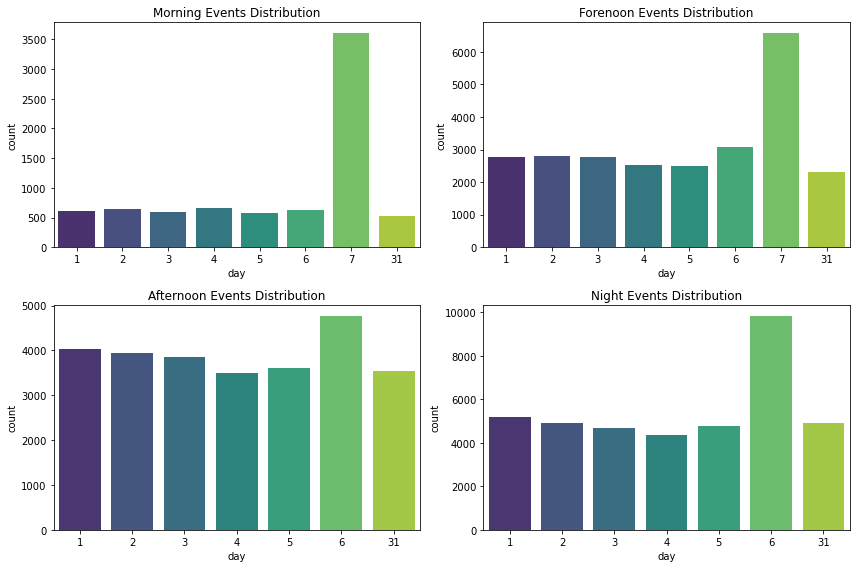

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# 根据不同时间段对数据进行分类
morning_data = data[data['maphour'] == 1]
forenoon_data = data[data['maphour'] == 2]
afternoon_data = data[data['maphour'] == 3]
night_data = data[data['maphour'] == 4]

# 绘制不同时间段的分布图
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.countplot(x='day', data=morning_data, palette='viridis')
plt.title('Morning Events Distribution')

plt.subplot(2, 2, 2)
sns.countplot(x='day', data=forenoon_data, palette='viridis')
plt.title('Forenoon Events Distribution')

plt.subplot(2, 2, 3)
sns.countplot(x='day', data=afternoon_data, palette='viridis')
plt.title('Afternoon Events Distribution')

plt.subplot(2, 2, 4)
sns.countplot(x='day', data=night_data, palette='viridis')
plt.title('Night Events Distribution')

plt.tight_layout()
plt.show()

# 针对转化率

## 针对每天的转化率变化

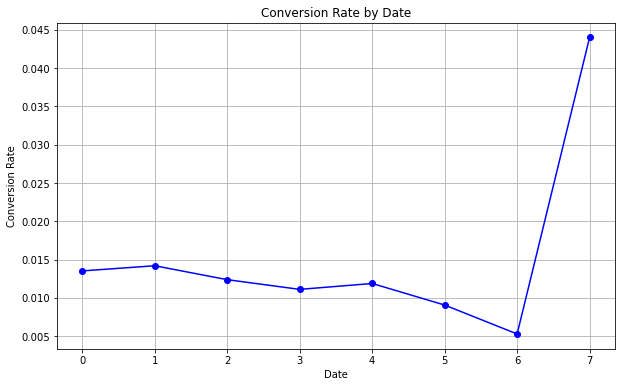

In [140]:
import matplotlib.pyplot as plt


data.loc[data['day'] == 31, 'day'] = 0
conversion_rate_by_date = data.groupby("day")["is_trade"].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(conversion_rate_by_date["day"], conversion_rate_by_date["is_trade"], marker='o', linestyle='-', color='b')
plt.title('Conversion Rate by Date')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.grid(True)
plt.show()

In [141]:
data['day'].unique()

array([3, 6, 0, 1, 5, 4, 2, 7])

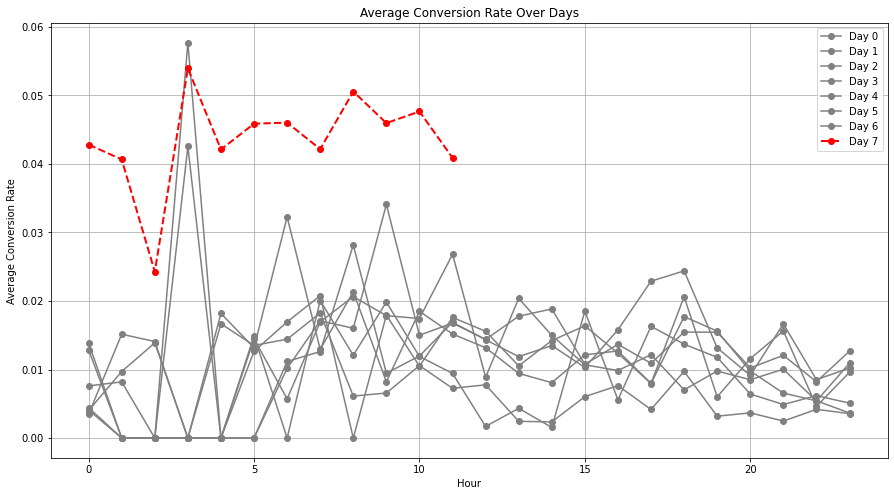

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))

# 创建一个包含颜色的字典
color_dict = {0: 'gray', 1: 'gray', 2: 'gray', 3: 'gray', 4: 'gray', 5: 'gray', 6: 'gray', 7: 'red'}

# 0到6天使用相同颜色
for day_of_interest in range(7):
    # 选择指定日期的数据
    selected_day_data = data[data['day'] == day_of_interest]

    # 计算每小时的平均转化率
    grouped_df = selected_day_data.groupby("hour")["is_trade"].mean().reset_index()

    color = color_dict[day_of_interest]

    plt.plot(grouped_df["hour"], grouped_df["is_trade"], label=f"Day {day_of_interest}", marker='o', color=color)

# 第7天使用特殊颜色
selected_day_data = data[data['day'] == 7]
grouped_df = selected_day_data.groupby("hour")["is_trade"].mean().reset_index()
color = color_dict[7]
plt.plot(grouped_df["hour"], grouped_df["is_trade"], label="Day 7", marker='o', linestyle='dashed', linewidth=2, color=color)

plt.title("Average Conversion Rate Over Days")
plt.xlabel("Hour")
plt.ylabel("Average Conversion Rate")
plt.legend()
plt.grid(True)
plt.show()

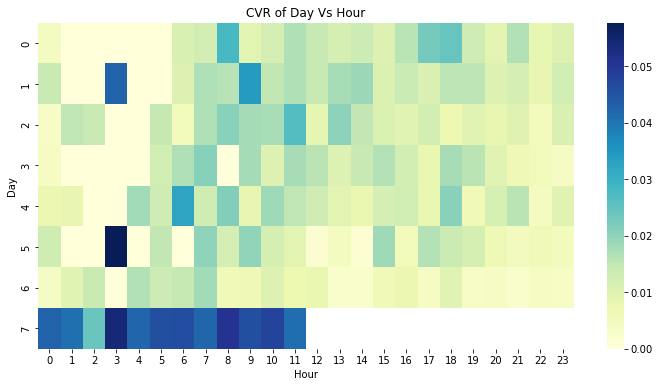

In [143]:
grouped_df = data.groupby(["day", "hour"])["is_trade"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('day', 'hour', 'is_trade')
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df,cmap="YlGnBu")
plt.title("CVR of Day Vs Hour")
plt.xlabel("Hour")
plt.ylabel("Day")
plt.show()